In [474]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

In [457]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

test_ids = test["CustomerID"]

#Определим выбросы и максимально чистим данные
#train['MonthlyIncome'].hist(bins = 50)
mask_income = ((train['MonthlyIncome'] >= 15000) & (train['MonthlyIncome'] <= 40000))
mask_durpitch = (train['DurationOfPitch'] <= 40)
mask_trips = (train['NumberOfTrips'] <= 10)
train = train[mask_income & mask_durpitch & mask_trips]

def female(x): #Переписывает ебаный Fe Male в Female (какой чёрт до этого додумался вообще)
    x = x['Gender']
    if x == 'Fe Male':
        return 'Female'
    else:
        return x
        
train['Gender'] = train.apply(female, axis = 1)
test['Gender'] = test.apply(female, axis = 1)

#Определим категории переменных
train.nunique()
binary_columns = ['TypeofContact', 'Gender', 'Passport','OwnCar']
category_columns = ['CityTier', 'Occupation', 'PreferredPropertyStar', 'MaritalStatus', 'ProductPitched', 'Designation']

all_columns = list(train.nunique().index)
nums_columns = [i for i in all_columns if i not in binary_columns+category_columns+['CustomerID', 'ProdTaken']]
print(nums_columns)

['Age', 'DurationOfPitch', 'NumberOfPersonVisiting', 'NumberOfFollowups', 'NumberOfTrips', 'PitchSatisfactionScore', 'NumberOfChildrenVisiting', 'MonthlyIncome']


In [458]:
#Заполнение нулей
try:
    rounded_duration = round(train["DurationOfPitch"].mean())
    rounded_monthly_income = round(train["MonthlyIncome"].mean())

    train["Age"] = train["Age"].fillna(train["Age"].mode().values[0])
    train["TypeofContact"] = train["TypeofContact"].fillna(
        train["TypeofContact"].mode().values[0]
    )
    train["DurationOfPitch"] = train["DurationOfPitch"].fillna(rounded_duration)
    train["NumberOfFollowups"] = train["NumberOfFollowups"].fillna(
        train["NumberOfFollowups"].mode().values[0]
    )
    train["PreferredPropertyStar"] = train["PreferredPropertyStar"].fillna(
        train["PreferredPropertyStar"].mode().values[0]
    )
    train["NumberOfTrips"] = train["NumberOfTrips"].fillna(
        train["NumberOfTrips"].mode().values[0]
    )
    #train["NumberOfChildrenVisiting"] = train["NumberOfChildrenVisiting"].fillna(
    #    train["NumberOfChildrenVisiting"].mode().values[0]
    #)
    train["MonthlyIncome"] = train["MonthlyIncome"].fillna(rounded_monthly_income)

    test["Age"] = test["Age"].fillna(test["Age"].mode().values[0])
    test["TypeofContact"] = test["TypeofContact"].fillna(
        test["TypeofContact"].mode().values[0]
    )
    test["DurationOfPitch"] = test["DurationOfPitch"].fillna(rounded_duration)
    test["NumberOfFollowups"] = test["NumberOfFollowups"].fillna(
        test["NumberOfFollowups"].mode().values[0]
    )
    test["PreferredPropertyStar"] = test["PreferredPropertyStar"].fillna(
        test["PreferredPropertyStar"].mode().values[0]
    )
    test["NumberOfTrips"] = test["NumberOfTrips"].fillna(
        test["NumberOfTrips"].mode().values[0]
    )
    # test["NumberOfChildrenVisiting"] = test["NumberOfChildrenVisiting"].fillna(
    #     test["NumberOfChildrenVisiting"].mode().values[0]
    # )
    test["MonthlyIncome"] = test["MonthlyIncome"].fillna(rounded_monthly_income)
except:
    print('NOT OK')
    raise BaseException
    pass


In [459]:
#Заполним бинарные переменные
print(binary_columns)
for col in binary_columns:
    name = pd.get_dummies(train[col]).columns[0]

    dummy = pd.get_dummies(train[col])[name]
    train[col] = dummy

    dummy = pd.get_dummies(test[col])[name]
    test[col] = dummy

['TypeofContact', 'Gender', 'Passport', 'OwnCar']


In [8]:
#Заполнение категориальных признаков, делаю target encoding (Общий)

def target_encoding(df: pd.DataFrame, columns: list, target: str, encode: bool = False, df_test: pd.DataFrame = None):
    """Target encoding

    Parameters
    ----------
    df : pd.DataFrame
        [Данные по, которым нужно произвести taget encoding]
    columns : list
        [Название столбцов категориальных переменных]
    target : str
        [Целевая переменная, по которой рассчитываются средние для категории]
    encode : bool, optional
        [Вернуть ли закодированные значения по каждой категории, использующиеся в target encoding, 
        возвращает только последнее вхождение], by default False

    Returns
    -------
    [pd.DataFrame or (pd.DataFrame, dict)]
        [В зависимости от опции возвращает результаты Target encoding]
    """    
    df = df
    cols = columns
    tg = target
    encodes = dict() #Сопоставление категории c её средней

    for col in cols:
        encodes = dict(df.groupby(col)[tg].mean())
        df[col] = df[col].map(df.groupby(col)[tg].mean())
        if isinstance(df_test, pd.DataFrame): #Хорошо бы доделать для случая с листом
            df_test[col] = df_test[col].map(encodes)

    if (encode == False) and isinstance(df_test, str):
        return df
    elif (encode == True) and isinstance(df_test, str):
        return df, encodes
    elif (encode == False) and isinstance(df_test, pd.DataFrame):
        return df, df_test
    else:
        return df, df_test, encodes

In [460]:
#Применяем Target encoding для категориальных
target = category_columns
train, test = target_encoding(train, columns=target, target='ProdTaken', df_test = test)

In [ ]:
# One-hot encoding для категориальных фичей
train["train"] = True
test["train"] = False

train_test = pd.concat([train, test])

train_test = pd.concat(
    [
        train_test,
        pd.get_dummies(train_test[category_columns], drop_first=True),
    ],
    axis=1,
)


train_test = train_test.drop(category_columns, axis=1)

train = train_test[train_test["train"] == True]
test = train_test[train_test["train"] == False]

del train_test
train = train.drop('train', axis = 1)
test = test.drop('train', axis = 1)
test = test.drop('ProdTaken', axis = 1)


In [461]:
# Целевая переменная

train_y = train["ProdTaken"]
train = train.drop(["ProdTaken"], axis=1)


In [462]:
#Выберем какие переменные нормализовать

to_norm = nums_columns + category_columns

In [463]:
#Нормализуем
def normalize(df_train, df_test, mode: str = 'mean'):
    if mode == 'mean':
        func = lambda df: (df - df.mean())/df.std()
    elif mode == 'mm':
        func = lambda df: (df-df.min())/(df.max()-df.min())
    return (func(df_train), func(df_test))


train[to_norm], test[to_norm] = normalize(train[to_norm], test[to_norm], mode = 'mm')

In [464]:
#Определим скоррелированные
corr_cols = ['NumberOfPersonVisiting', 'ProductPitched', 'NumberOfChildrenVisiting', 'Designation', 'MonthlyIncome'] #Определяются на основе выведенных данных далее
exclude = ['NumberOfChildrenVisiting', 'ProductPitched', 'Designation'] #Определяются на основе выведенных данных далее

cr = train.corr()
print(cr[abs(cr) >= 0.5].count())
#Очистим коррелированность
train.drop(exclude, axis = 1, inplace = True)
test.drop(exclude, axis = 1, inplace = True)

for name in exclude:
    if name in binary_columns:
        binary_columns.remove(name)
    elif name in category_columns:
        category_columns.remove(name)
    elif name in nums_columns:
        nums_columns.remove(name)
    else:
        print('Didnt find type of variable')
cr = train.corr()
print(cr[abs(cr) >= 0.5].count())
train


CustomerID                  1
Age                         1
TypeofContact               1
CityTier                    1
DurationOfPitch             1
Occupation                  1
Gender                      1
NumberOfPersonVisiting      2
NumberOfFollowups           1
ProductPitched              3
PreferredPropertyStar       1
MaritalStatus               1
NumberOfTrips               1
Passport                    1
PitchSatisfactionScore      1
OwnCar                      1
NumberOfChildrenVisiting    2
Designation                 3
MonthlyIncome               3
dtype: int64
CustomerID                1
Age                       1
TypeofContact             1
CityTier                  1
DurationOfPitch           1
Occupation                1
Gender                    1
NumberOfPersonVisiting    1
NumberOfFollowups         1
PreferredPropertyStar     1
MaritalStatus             1
NumberOfTrips             1
Passport                  1
PitchSatisfactionScore    1
OwnCar                   

,CustomerID,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,MonthlyIncome
0,1,0.395349,0,0.000000,0.129032,0.000000,0,0.75,0.8,0.00000,0.026605,0.571429,1,1.00,0,0.239854
1,2,0.627907,0,0.000000,0.064516,0.000000,0,0.75,0.2,1.00000,0.026605,0.428571,1,0.50,0,0.339774
2,3,0.372093,0,0.891761,0.709677,0.000000,0,0.50,0.0,0.00000,1.000000,0.142857,1,0.50,1,0.190930
3,4,0.790698,1,0.000000,0.064516,0.017999,1,0.25,0.8,1.00000,0.541094,0.571429,1,0.25,0,0.447900
5,6,0.953488,0,0.891761,0.387097,0.017999,0,0.50,0.6,0.00000,1.000000,0.142857,1,0.50,1,0.729707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3883,3884,0.744186,1,0.000000,0.096774,0.000000,0,0.50,0.4,1.00000,0.026605,0.142857,1,1.00,0,0.746206
3884,3885,0.186047,0,0.000000,0.032258,0.000000,1,0.25,0.6,0.00000,0.026605,0.142857,0,0.75,1,0.084877
3885,3886,0.255814,0,0.000000,0.580645,0.017999,0,0.75,0.4,1.00000,0.541094,0.142857,1,1.00,1,0.367478
3886,3887,0.093023,0,0.000000,0.193548,0.000000,0,0.25,0.2,0.31528,0.026605,0.142857,0,0.75,1,0.058188


In [465]:
train.shape

(3463, 16)

In [466]:
train.head()

,CustomerID,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,MonthlyIncome
0,1,0.395349,0,0.000000,0.129032,0.000000,0,0.75,0.8,0.0,0.026605,0.571429,1,1.00,0,0.239854
1,2,0.627907,0,0.000000,0.064516,0.000000,0,0.75,0.2,1.0,0.026605,0.428571,1,0.50,0,0.339774
2,3,0.372093,0,0.891761,0.709677,0.000000,0,0.50,0.0,0.0,1.000000,0.142857,1,0.50,1,0.190930
3,4,0.790698,1,0.000000,0.064516,0.017999,1,0.25,0.8,1.0,0.541094,0.571429,1,0.25,0,0.447900
5,6,0.953488,0,0.891761,0.387097,0.017999,0,0.50,0.6,0.0,1.000000,0.142857,1,0.50,1,0.729707


In [467]:
test.shape

(1000, 16)

In [312]:
def cv_and_predict(
    df_train,
    df_test,
    train_y,
    model_kf,
    n_splits=5,
    random_state=42,
    verbose=True,
):
    """
    Функция для кросс-валидации и предикта на тест

    :param df_train: Трейн-датафрейм
    :param df_test: Тест-датафрейм
    :param train_y: Ответы на трейн
    :param model_kf: Модель, которую мы хотим учить
    :param n_splits: Количество сплитов для StratifiedKFold
    :param random_state: random_state для StratifiedKFold
    :param verbose: Делаем ли print'ы

    :return: pred_test: Предсказания на тест; oof_df: OOF предсказания
    """

    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # В датафрейме oof_df будут храниться настоящий таргет трейна и OOF предсказания на трейн.
    # Инициализируем prediction_oof нулями и будем заполнять предсказаниями в процессе валидации
    oof_df = pd.DataFrame()
    oof_df["target"] = train_y
    oof_df["prediction_oof"] = np.zeros(oof_df.shape[0])

    # Список с метриками по фолдам
    metrics = []

    # Предсказания на тест. Инициализируем нулями и будем заполнять предсказаниями в процессе валидации.
    # Наши предсказания будут усреднением n_splits моделей
    pred_test = np.zeros(df_test.shape[0])

    # Кросс-валидация
    for i, (train_index, valid_index) in enumerate(kf.split(df_train, train_y)):
        if verbose:
            print(f"fold_{i} started")

        X_train = df_train.loc[train_index]
        y_train = train_y.loc[train_index].values

        X_valid = df_train.loc[valid_index]
        y_valid = train_y.loc[valid_index].values

        model_kf.fit(X_train, y_train)
        prediction = model_kf.predict(df_test)
        pred_test += prediction / n_splits
        
        prediction_kf = model_kf.predict(X_valid)
        oof_df.loc[valid_index, "prediction_oof"] = prediction_kf

        cur_metric = roc_auc_score(y_valid, prediction_kf)
        metrics.append(cur_metric)
        if verbose:
            print(f"metric_{i}: {cur_metric}")
            print()
            print("_" * 100)
            print()

    metric_OOF = roc_auc_score(train_y, oof_df["prediction_oof"])

    if verbose:
        print(f"metric_OOF: {metric_OOF}")
        print(f"metric_AVG: {np.mean(metrics)}")
        print(f"metric_std: {np.std(metrics)}")
        print()
        print("*" * 100)
        print()

    return pred_test, oof_df, metric_OOF

In [313]:
#n_neighbors = 3
res = list()
for k in tqdm(range(1, 8, 1)):

    model_knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)

    pred_test, oof_df, metric_OOF = cv_and_predict(
        train, test, train_y, model_knn, n_splits=10, verbose=False
    )
    res.append((k, metric_OOF))
max_ = max(res, key = lambda x: x[1])
print(f'Neighbours: {max_[0]}, metric is {max_[1]:.4f}')


  0%|          | 0/7 [00:00<?, ?it/s]

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Int64Index([   4,   11,   41,   42,   44,\n            ...\n            3422, 3436, 3441, 3442, 3461],\n           dtype='int64', length=340). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

In [468]:
test

,CustomerID,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,MonthlyIncome
0,3889,0.279070,0,0.000000,0.967742,0.151291,1,1.000000,0.8,1.00000,0.541094,0.095238,1,0.00,1,0.078070
1,3890,0.418605,1,0.000000,0.064516,0.151291,0,1.000000,0.6,1.00000,0.026605,0.238095,1,0.00,1,0.058825
2,3891,0.441860,0,0.000000,0.225806,0.000000,1,0.666667,0.8,1.00000,0.000000,0.047619,0,0.25,0,1.000000
3,3892,0.581395,0,0.891761,0.064516,0.000000,0,0.666667,0.6,0.00000,0.000000,0.095238,1,0.50,0,0.091643
4,3893,0.767442,0,0.000000,0.387097,1.000000,0,1.000000,0.8,0.00000,1.000000,0.333333,1,1.00,1,0.159250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,4884,0.465116,0,0.891761,0.387097,0.000000,1,0.666667,0.8,0.00000,0.026605,0.142857,0,0.75,1,0.113259
996,4885,0.465116,1,0.000000,0.096774,0.151291,1,0.666667,0.6,0.31528,0.026605,0.190476,1,0.50,1,0.017649
997,4886,0.093023,1,0.000000,0.129032,0.000000,0,0.333333,0.6,0.00000,0.000000,0.000000,0,0.50,1,0.022306
998,4887,0.767442,0,0.000000,0.129032,0.151291,1,0.666667,0.4,0.31528,1.000000,0.142857,1,1.00,1,0.153927


In [473]:
l = list()
for k in tqdm(range(1, 15, 1)):
    p_metrics = np.linspace(1,3, 5)
    for p in p_metrics:
        model_knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1, p = p)
        score_l = cross_val_score(estimator= model_knn, X = train.loc[:, 'Age':], y = train_y, scoring = 'roc_auc', cv = 10)
        l.append((k, p, np.mean(score_l)))
        print(f'Соседей: {k}, p: {p} score: {score_l.mean():.4f}')


  0%|          | 0/14 [00:00<?, ?it/s]

Соседей: 1, p: 1.0 score: 0.8333
Соседей: 1, p: 1.5 score: 0.8296
Соседей: 1, p: 2.0 score: 0.8271
Соседей: 1, p: 2.5 score: 0.8301
Соседей: 1, p: 3.0 score: 0.8249
Соседей: 2, p: 1.0 score: 0.8635
Соседей: 2, p: 1.5 score: 0.8487
Соседей: 2, p: 2.0 score: 0.8453
Соседей: 2, p: 2.5 score: 0.8439
Соседей: 2, p: 3.0 score: 0.8436
Соседей: 3, p: 1.0 score: 0.8749
Соседей: 3, p: 1.5 score: 0.8538
Соседей: 3, p: 2.0 score: 0.8495
Соседей: 3, p: 2.5 score: 0.8459
Соседей: 3, p: 3.0 score: 0.8430
Соседей: 4, p: 1.0 score: 0.8714
Соседей: 4, p: 1.5 score: 0.8466
Соседей: 4, p: 2.0 score: 0.8398
Соседей: 4, p: 2.5 score: 0.8342
Соседей: 4, p: 3.0 score: 0.8315
Соседей: 5, p: 1.0 score: 0.8630
Соседей: 5, p: 1.5 score: 0.8339
Соседей: 5, p: 2.0 score: 0.8231
Соседей: 5, p: 2.5 score: 0.8194
Соседей: 5, p: 3.0 score: 0.8174
Соседей: 6, p: 1.0 score: 0.8564
Соседей: 6, p: 1.5 score: 0.8293
Соседей: 6, p: 2.0 score: 0.8148
Соседей: 6, p: 2.5 score: 0.8130
Соседей: 6, p: 3.0 score: 0.8124
Соседей: 7

In [470]:
val = max(l, key = lambda x: x[2])
print(f'Оптимальных соседей: {val[0]}, metric_p: {val[1]}, ROC-AUC: {val[2]:.4f}')

Оптимальных соседей: 3, metric_p: 1.0, ROC-AUC: 0.8912


In [471]:
#Тогда воспользуемся для предсказания таким количеством соседей
p = val[1]
print(p)
model_knn_res = KNeighborsClassifier(n_neighbors= 3, n_jobs=-1, p = val[1])
model_knn_res.fit(train.loc[:, "Age":], train_y)

1.0


KNeighborsClassifier(n_jobs=-1, n_neighbors=3, p=1.0)

In [472]:
train_predict_res = model_knn_res.predict(train.loc[:, 'Age':])
train_predict_res
print(roc_auc_score(y_true=train_y, y_score=train_predict_res))
cross_val_score(estimator= model_knn_res, X = train.loc[:, 'Age':], y = train_y, scoring = 'roc_auc', cv = 5)

0.919959134693348


array([0.88456085, 0.87342003, 0.85681683, 0.86623377, 0.89352002])

In [249]:
pred_test = model_knn_res.predict_proba(test.loc[:, 'Age':])[:, 1]

In [241]:
test.loc[:, 'Age':].isnull().sum()

Age                       0
TypeofContact             0
CityTier                  0
DurationOfPitch           0
Occupation                0
Gender                    0
NumberOfPersonVisiting    0
NumberOfFollowups         0
PreferredPropertyStar     0
MaritalStatus             0
NumberOfTrips             0
Passport                  0
PitchSatisfactionScore    0
OwnCar                    0
MonthlyIncome             0
dtype: int64

In [253]:
len(pred_test)

1000

In [255]:
train

,CustomerID,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,MonthlyIncome
0,1,0.395349,0,0.0,0.129032,0.174850,0,0.75,0.8,0.0,0.143967,0.571429,1,1.00,0,0.239854
1,2,0.627907,0,0.0,0.064516,0.174850,0,0.75,0.2,1.0,0.143967,0.428571,1,0.50,0,0.339774
2,3,0.372093,0,1.0,0.709677,0.174850,0,0.50,0.0,0.0,0.332776,0.142857,1,0.50,1,0.190930
3,4,0.790698,1,0.0,0.064516,0.189702,1,0.25,0.8,1.0,0.243762,0.571429,1,0.25,0,0.447900
5,6,0.953488,0,1.0,0.387097,0.189702,0,0.50,0.6,0.0,0.332776,0.142857,1,0.50,1,0.729707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3883,3884,0.744186,1,0.0,0.096774,0.174850,0,0.50,0.4,1.0,0.143967,0.142857,1,1.00,0,0.746206
3884,3885,0.186047,0,0.0,0.032258,0.174850,1,0.25,0.6,0.0,0.143967,0.142857,0,0.75,1,0.084877
3885,3886,0.255814,0,0.0,0.580645,0.189702,0,0.75,0.4,1.0,0.243762,0.142857,1,1.00,1,0.367478
3886,3887,0.093023,0,0.0,0.193548,0.174850,0,0.25,0.2,0.5,0.143967,0.142857,0,0.75,1,0.058188


In [254]:
submission = pd.DataFrame()
submission["CustomerID"] = test_ids
submission["ProdTaken"] = pred_test

submission.to_csv("submission.csv", index=False)

  0%|          | 0/19 [00:00<?, ?it/s]

Depth: 1, Score: 0.7428
Depth: 2, Score: 0.7559
Depth: 3, Score: 0.7700
Depth: 4, Score: 0.7891
Depth: 5, Score: 0.8084
Depth: 6, Score: 0.8336
Depth: 7, Score: 0.8587
Depth: 8, Score: 0.8824
Depth: 9, Score: 0.9060
Depth: 10, Score: 0.9236
Depth: 11, Score: 0.9351
Depth: 12, Score: 0.9467
Depth: 13, Score: 0.9523
Depth: 14, Score: 0.9521
Depth: 15, Score: 0.9552
Depth: 16, Score: 0.9565
Depth: 17, Score: 0.9571
Depth: 18, Score: 0.9561
Depth: 19, Score: 0.9582


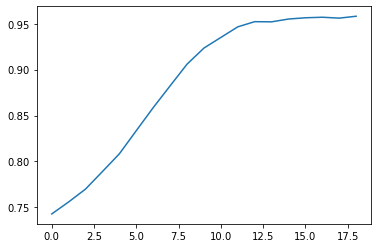

In [475]:
#Тут юзаем рандомный лес
d = 3
scores = list()
for d in tqdm(range(1, 20, 1)):
    rf = RandomForestClassifier(max_depth=d, criterion= 'gini', n_estimators= 200)
    score_l = cross_val_score(estimator=rf, X = train.loc[:, 'Age':], y = train_y, scoring= 'roc_auc', cv = 10)
    score = score_l.mean()
    scores.append(score)
    print(f'Depth: {d}, Score: {score:.4f}')

plt.plot(scores)
plt.show()

In [403]:
rf = RandomForestClassifier(max_depth=14, criterion= 'entropy', n_estimators=250)
rf.fit(train.loc[:, 'Age':], train_y)


RandomForestClassifier(criterion='entropy', max_depth=14, n_estimators=250)

In [404]:
pred_train = rf.predict(train.loc[:, 'Age':])
print(roc_auc_score(train_y, pred_train))
pred_test = rf.predict_proba(test.loc[:, 'Age':])[:, 1]

0.9719696969696969


In [266]:
submission = pd.DataFrame()
submission["CustomerID"] = test_ids
submission["ProdTaken"] = pred_test

submission.to_csv("submission.csv", index=False)

  0%|          | 0/7 [00:00<?, ?it/s]

Parameter: 8, Score: 0.9579
Parameter: 9, Score: 0.9634
Parameter: 10, Score: 0.9622
Parameter: 11, Score: 0.9658
Parameter: 12, Score: 0.9655
Parameter: 13, Score: 0.9536
Parameter: 14, Score: 0.9251


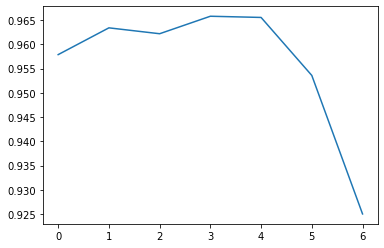

In [485]:
#Тут бустинг

#Тут юзаем рандомный лес
d = 3
scores = list()
for x in tqdm(range(8, 15, 1)):
    model_gb = GradientBoostingClassifier(n_estimators= 200, learning_rate= 0.2, max_depth = x)
    score_l = cross_val_score(estimator=model_gb, X = train.loc[:, 'Age':], y = train_y, scoring= 'roc_auc', cv = 10)
    score = score_l.mean()
    scores.append(score)
    print(f'Parameter: {x}, Score: {score:.4f}')

plt.plot(scores)
plt.show()


In [501]:
np.set_printoptions(suppress=True) #prevent numpy exponential 
model_gb = GradientBoostingClassifier(n_estimators= 200, learning_rate= 0.2, max_depth = 12)
model_gb.fit(train.loc[:, 'Age':], train_y)
tr_predict = model_gb.predict(train.loc[:, 'Age':])
print(roc_auc_score(train_y, pred_train))
pred_test = model_gb.predict_proba(test.loc[:, 'Age':])[:, 1]

0.9719696969696969


In [502]:
submission = pd.DataFrame()
submission["CustomerID"] = test_ids
submission["ProdTaken"] = pred_test

submission.to_csv("submission.csv", index=False)